# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

+ Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
+ Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

# Описание данных 

Оригинальный датасет разбит на тестовый, тренировочный и валидационный.
В нашем распоряжении одна папка со всеми изображениями /datasets/faces/ и csv-файл labels.csv с метками, который содержит две колонки:

file_name - имя файла изображения
real_age - возраст человека на фотографии.
В оригинальном датасете представлены разнообразные изображения с фотографиями людей во весь рост, портретные фотографии. Для каждого изображения авторы также предоставляют соответствующее изображение, которое содержит только изображения лица.

В нашем распоряжении уже обработанный датасет с лицами, таким образом, задачу детекции лиц производить не нужно.

## Исследовательский анализ данных

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from PIL import Image
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
df = pd.read_csv("/datasets/faces/labels.csv")

In [4]:
df.shape[0]

7591

In [5]:
print(df.head(10))
df.info()

    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17
5  000005.jpg        27
6  000006.jpg        24
7  000007.jpg        43
8  000008.jpg        26
9  000009.jpg        39
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [6]:
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


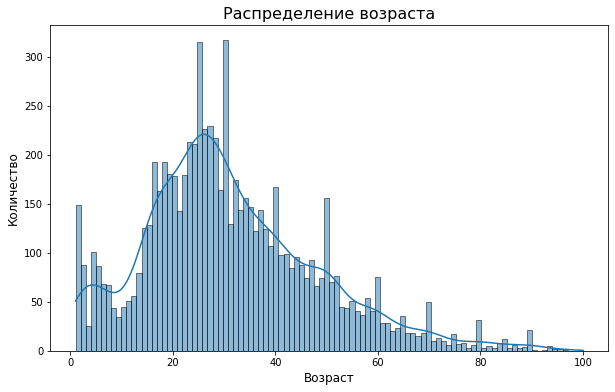

In [7]:
plt.figure(figsize=(10, 6))  
sns.histplot(data=df, x='real_age', bins=100, kde=True) 

plt.title('Распределение возраста', fontsize=16)
plt.xlabel('Возраст', fontsize=12)
plt.ylabel('Количество', fontsize=12)

plt.show()

Средний возраст людей на фотографиях составляет примерно 30 лет. Также можно заметить пики на возрастах, кратных 10. Это может быть связано с тем, что так проще соотносить фото и примерный возраст (разница между 35 и 40 довольно условна в отличие от 30 и 40) 

In [11]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=42
)

images, target = next(train_gen_flow) 

Found 7591 validated image filenames.


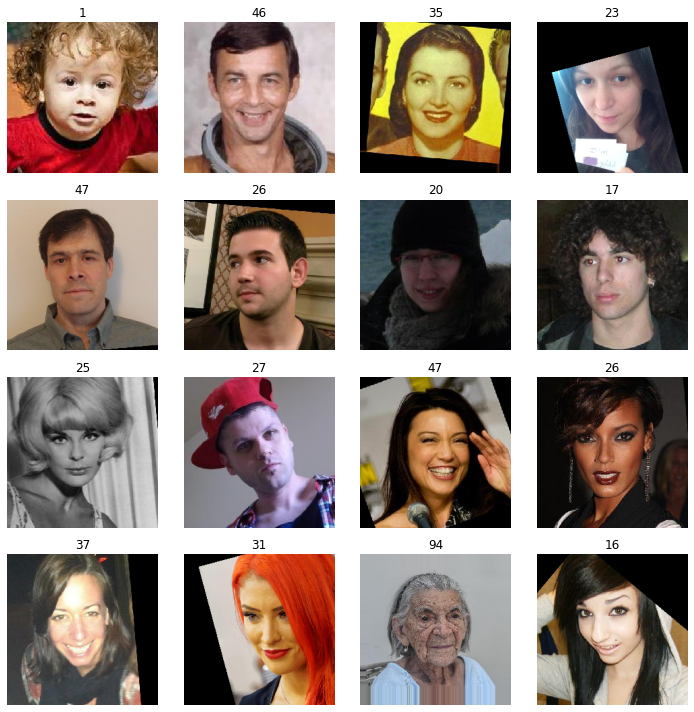

In [12]:
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i])
    plt.axis('off') 
    plt.title(target[i])

plt.tight_layout()
plt.show()

Отобразили 16 произвольных фотографий из датасета. Можем заметить, что некоторые фотографии смещены относительно центра, некоторые сделаны в плохом освещении, либо с использованием фильтров. Также есть как черно-белые снимки, так и обычные, все это может сказаться на точности предсказания возраста

## Обучение модели

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow import keras
import pandas as pd


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')

    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1 / 255.,
        horizontal_flip=True,
        width_shift_range=0.15,
        height_shift_range=0.15,
        zoom_range=0.1,
    )

    return datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=123,
    )


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')

    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1 / 255.)

    return datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=123,
    )


def create_model(input_shape):
    backbone = ResNet50(
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        input_shape=input_shape,
        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='mean_squared_error', metrics=['mae'])  # Используем 'mae' вместо 'mean_absolute_error'
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=17,
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              epochs=epochs, batch_size=batch_size,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/17
178/178 - 109s - loss: 239.8520 - mae: 11.0834 - val_loss: 990.2468 - val_mae: 26.5708
Epoch 2/17
178/178 - 97s - loss: 90.2774 - mae: 7.1341 - val_loss: 964.5021 - val_mae: 26.1193
Epoch 3/17
178/178 - 93s - loss: 69.6682 - mae: 6.2932 - val_loss: 350.2582 - val_mae: 13.8598
Epoch 4/17
178/178 - 92s - loss: 57.5893 - mae: 5.7829 - val_loss: 131.5870 - val_mae: 8.7637
Epoch 5/17
178/178 - 92s - loss: 47.4858 - mae: 5.2591 - val_loss: 80.4152 - val_mae: 6.6428
Epoch 6/17
178/178 - 92s - loss: 39.3790 - mae: 4.8099 - val_loss: 79.5058 - val_mae: 6.6056
Epoch 7/17
178/178 - 92s - loss: 36.1971 - mae: 4.6509 - val_loss: 97.1155 - val_mae: 7.5905
Epoch 8/17
178/178 - 92s - loss: 33.3484 - mae: 4.4273 - val_loss: 75.1796 - val_mae: 6.7462
Epoch 9/17
178/178 - 92s - loss: 28.8324 - mae: 4.1622 - val_loss: 83.1345 - val_mae: 6.7276
Epoch 10/17
178/178 - 92s - loss: 26.4789 - mae: 3.9893 - val_loss: 64.4350 - val_mae: 5.8626
Epoch 11/17
178/178 - 92s - loss: 22.3171 - mae: 3.6818 - val_loss: 73.6086 - val_mae: 6.4635
Epoch 12/17
178/178 - 92s - loss: 20.8975 - mae: 3.5332 - val_loss: 68.3375 - val_mae: 5.9858
Epoch 13/17
178/178 - 91s - loss: 18.7761 - mae: 3.3311 - val_loss: 67.2531 - val_mae: 6.0318
Epoch 14/17
178/178 - 91s - loss: 17.5516 - mae: 3.2293 - val_loss: 65.1508 - val_mae: 5.9766
Epoch 15/17
178/178 - 92s - loss: 16.8694 - mae: 3.1695 - val_loss: 71.7399 - val_mae: 6.2935
Epoch 16/17
178/178 - 92s - loss: 15.5151 - mae: 3.0439 - val_loss: 63.7749 - val_mae: 5.7892
Epoch 17/17
178/178 - 92s - loss: 13.0128 - mae: 2.7734 - val_loss: 75.7427 - val_mae: 6.5072

```

## Анализ обученной модели

Мы обучили модель, в результате достигли значения **MAE = 6.507** за 17 эпох.

В среднем модель ошибается примерно на 7 лет при предсказании возраста на тестовой выборке и на 5 на тренировочной. Явно можно сказать, что модель переобучилась

Можно улучшить качество предсказаний модели, если:

+ Обучать модель на большем количестве циклов обучения
+ Избавиться от ошибок в детекции лиц в изображениях датасета.

В контексте решения поставленной задачи это можно использовать для упрощения:
+ Анализа покупки и предложения товаров, которые могут заинтересовать покупателей этой возрастной группы;
+ Контроля добросовестности кассиров при продаже алкоголя (на данный момент с учетом средней ошибки модели в 7 лет этот пункт условный, но это можно исправить с помощью применения более продвинутых моделей, либо обработки датасета) 

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы